In [7]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from IPython.display import clear_output
import os
from skimage.util import img_as_float, img_as_ubyte

In [8]:
def imshow_orthogonal_view(sitkImage, origin = None, title=None):
    """
    Display the orthogonal views of a 3D volume from the middle of the volume.

    Parameters
    ----------
    sitkImage : SimpleITK image
        Image to display.
    origin : array_like, optional
        Origin of the orthogonal views, represented by a point [x,y,z].
        If None, the middle of the volume is used.
    title : str, optional
        Super title of the figure.

    Note:
    On the axial and coronal views, patient's left is on the right
    On the sagittal view, patient's anterior is on the left
    """
    data = sitk.GetArrayFromImage(sitkImage)

    if origin is None:
        origin = np.array(data.shape) // 2

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    data = img_as_ubyte(data/np.max(data))
    axes[0].imshow(data[origin[0], ::-1, ::-1], cmap='gray')
    axes[0].set_title('Axial')

    axes[1].imshow(data[::-1, origin[1], ::-1], cmap='gray')
    axes[1].set_title('Coronal')

    axes[2].imshow(data[::-1, ::-1, origin[2]], cmap='gray')
    axes[2].set_title('Sagittal')

    [ax.set_axis_off() for ax in axes]

    if title is not None:
        fig.suptitle(title, fontsize=16)

def overlay_slices(sitkImage0, sitkImage1, origin = None, title=None):
    """
    Overlay the orthogonal views of a two 3D volume from the middle of the volume.
    The two volumes must have the same shape. The first volume is displayed in red,
    the second in green.

    Parameters
    ----------
    sitkImage0 : SimpleITK image
        Image to display in red.
    sitkImage1 : SimpleITK image
        Image to display in green.
    origin : array_like, optional
        Origin of the orthogonal views, represented by a point [x,y,z].
        If None, the middle of the volume is used.
    title : str, optional
        Super title of the figure.

    Note:
    On the axial and coronal views, patient's left is on the right
    On the sagittal view, patient's anterior is on the left
    """
    vol0 = sitk.GetArrayFromImage(sitkImage0)
    vol1 = sitk.GetArrayFromImage(sitkImage1)

    if vol0.shape != vol1.shape:
        raise ValueError('The two volumes must have the same shape.')
    if np.min(vol0) < 0 or np.min(vol1) < 0: # Remove negative values - Relevant for the noisy images
        vol0[vol0 < 0] = 0
        vol1[vol1 < 0] = 0
    if origin is None:
        origin = np.array(vol0.shape) // 2

    sh = vol0.shape
    R = img_as_ubyte(vol0/np.max(vol0))
    G = img_as_ubyte(vol1/np.max(vol1))

    vol_rgb = np.zeros(shape=(sh[0], sh[1], sh[2], 3), dtype=np.uint8)
    vol_rgb[:, :, :, 0] = R
    vol_rgb[:, :, :, 1] = G

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(vol_rgb[origin[0], ::-1, ::-1, :])
    axes[0].set_title('Axial')

    axes[1].imshow(vol_rgb[::-1, origin[1], ::-1, :])
    axes[1].set_title('Coronal')

    axes[2].imshow(vol_rgb[::-1, ::-1, origin[2], :])
    axes[2].set_title('Sagittal')

    [ax.set_axis_off() for ax in axes]

    if title is not None:
        fig.suptitle(title, fontsize=16)

In [9]:
def composite2affine(composite_transform, result_center=None):
    """
    Combine all of the composite transformation's contents to form an equivalent affine transformation.
    Args:
        composite_transform (SimpleITK.CompositeTransform): Input composite transform which contains only
                                                            global transformations, possibly nested.
        result_center (tuple,list): The desired center parameter for the resulting affine transformation.
                                    If None, then set to [0,...]. This can be any arbitrary value, as it is
                                    possible to change the transform center without changing the transformation
                                    effect.
    Returns:
        SimpleITK.AffineTransform: Affine transformation that has the same effect as the input composite_transform.

    Source:
        https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks/blob/master/Python/22_Transforms.ipynb
    """
    # Flatten the copy of the composite transform, so no nested composites.
    flattened_composite_transform = sitk.CompositeTransform(composite_transform)
    flattened_composite_transform.FlattenTransform()
    tx_dim = flattened_composite_transform.GetDimension()
    A = np.eye(tx_dim)
    c = np.zeros(tx_dim) if result_center is None else result_center
    t = np.zeros(tx_dim)
    for i in range(flattened_composite_transform.GetNumberOfTransforms() - 1, -1, -1):
        curr_tx = flattened_composite_transform.GetNthTransform(i).Downcast()
        # The TranslationTransform interface is different from other
        # global transformations.
        if curr_tx.GetTransformEnum() == sitk.sitkTranslation:
            A_curr = np.eye(tx_dim)
            t_curr = np.asarray(curr_tx.GetOffset())
            c_curr = np.zeros(tx_dim)
        else:
            A_curr = np.asarray(curr_tx.GetMatrix()).reshape(tx_dim, tx_dim)
            c_curr = np.asarray(curr_tx.GetCenter())
            # Some global transformations do not have a translation
            # (e.g. ScaleTransform, VersorTransform)
            get_translation = getattr(curr_tx, "GetTranslation", None)
            if get_translation is not None:
                t_curr = np.asarray(get_translation())
            else:
                t_curr = np.zeros(tx_dim)
        A = np.dot(A_curr, A)
        t = np.dot(A_curr, t + c - c_curr) + t_curr + c_curr - c

    return sitk.AffineTransform(A.flatten(), t, c)

In [10]:
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations

    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations

    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations

    metric_values.append(registration_method.GetMetricValue())
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()

# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the
# metric_values list.
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

def command_iteration(method):
    print(
        f"{method.GetOptimizerIteration():3} "
        + f"= {method.GetMetricValue():10.5f} "
        + f": {method.GetOptimizerPosition()}"
    )

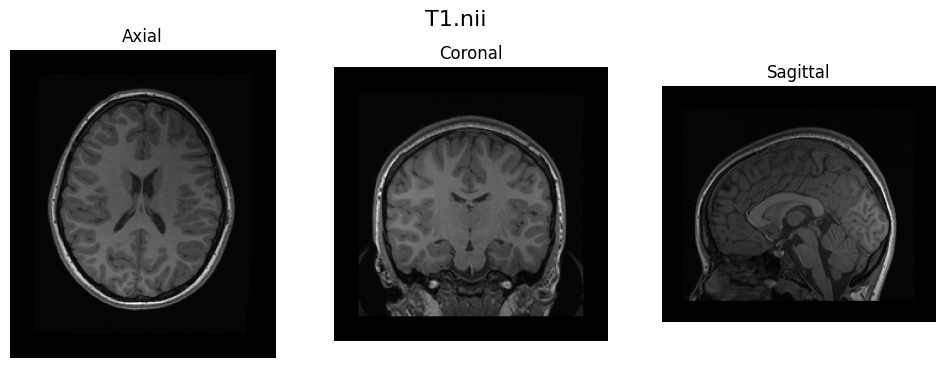

In [11]:
dir_in = 'data/'
vol_sitk = sitk.ReadImage(dir_in + 'ImgT1.nii')

imshow_orthogonal_view(vol_sitk, title='T1.nii')

In [12]:
import numpy as np

def rotation_matrix(pitch, roll, yaw):
    """
    Returns the rotation matrix for the given roll, pitch, and yaw angles.

    Arguments:
    - pitch: float, pitch angle in radians.
    - roll: float, roll angle in radians.
    - yaw: float, yaw angle in radians.

    Returns:
    - rotation_matrix: numpy array of shape (3, 3), the rotation matrix.
    """
    cos_pitch = np.cos(pitch)
    sin_pitch = np.sin(pitch)
    cos_roll = np.cos(roll)
    sin_roll = np.sin(roll)
    cos_yaw = np.cos(yaw)
    sin_yaw = np.sin(yaw)

    # Calculate the rotation matrix
    rotation_matrix = np.array([[cos_yaw*cos_pitch,
                                 cos_yaw*sin_pitch*sin_roll - sin_yaw*cos_roll,
                                 cos_yaw*sin_pitch*cos_roll + sin_yaw*sin_roll],
                                [sin_yaw*cos_pitch,
                                 sin_yaw*sin_pitch*sin_roll + cos_yaw*cos_roll,
                                 sin_yaw*sin_pitch*cos_roll - cos_yaw*sin_roll],
                                [-sin_pitch,
                                 cos_pitch*sin_roll,
                                 cos_pitch*cos_roll]])

    return rotation_matrix



In [13]:
# Define the roll rotation in radians
angle = 25  # degrees
pitch_radians = np.deg2rad(angle)

# Create the Affine transform and set the rotation
transform = sitk.AffineTransform(3)

centre_image = np.array(vol_sitk.GetSize()) / 2 - 0.5 # Image Coordinate System
centre_world = vol_sitk.TransformContinuousIndexToPhysicalPoint(centre_image) # World Coordinate System
rot_matrix = rotation_matrix(pitch_radians, 0, 0)[:3, :3] # SimpleITK inputs the rotation and the translation separately

transform.SetCenter(centre_world) # Set the rotation centre
transform.SetMatrix(rot_matrix.T.flatten())

# Apply the transformation to the image
ImgT1_A = sitk.Resample(vol_sitk, transform)

# Save the rotated image
sitk.WriteImage(ImgT1_A, dir_in + 'ImgT1_A.nii')

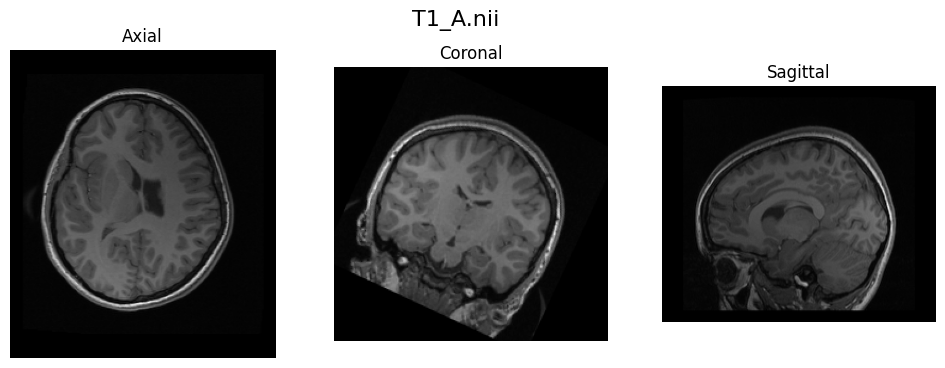

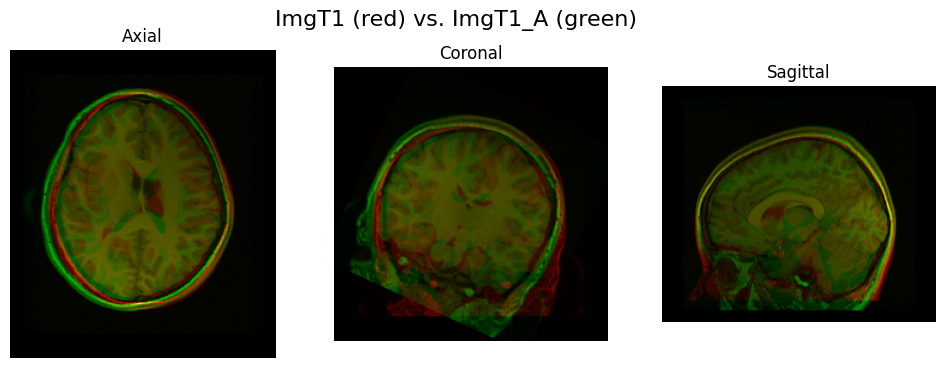

In [14]:
imshow_orthogonal_view(ImgT1_A, title='T1_A.nii')
overlay_slices(vol_sitk, ImgT1_A, title = 'ImgT1 (red) vs. ImgT1_A (green)')

In [15]:
dir_in = 'data/'
fixed = sitk.ReadImage(dir_in + 'ImgT1.nii')
moving = sitk.ReadImage(dir_in + 'ImgT1_A.nii')

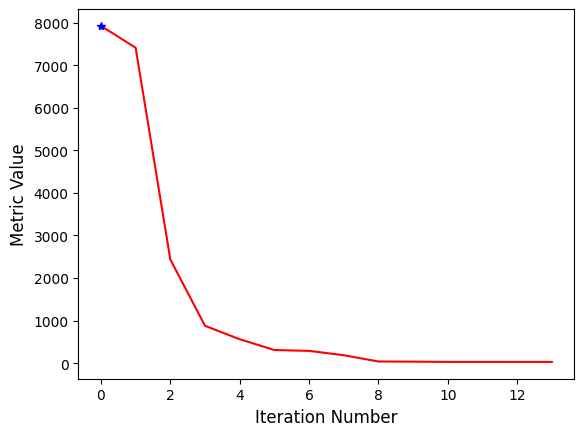

In [16]:
# Set the registration - Fig. 1 from the Theory Note
R = sitk.ImageRegistrationMethod()

# Set a one-level the pyramid scheule. [Pyramid step]
R.SetShrinkFactorsPerLevel(shrinkFactors = [2])
R.SetSmoothingSigmasPerLevel(smoothingSigmas=[0])
R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the interpolator [Interpolation step]
R.SetInterpolator(sitk.sitkLinear)

# Set the similarity metric [Metric step]
R.SetMetricAsMeanSquares()

# Set the sampling strategy [Sampling step]
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.50)

# Set the optimizer [Optimization step]
R.SetOptimizerAsPowell(stepLength=0.1, numberOfIterations=25)

# Initialize the transformation type to rigid
initTransform = sitk.Euler3DTransform()
R.SetInitialTransform(initTransform, inPlace=False)

# Some extra functions to keep track to the optimization process
# R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R)) # Print the iteration number and metric value
R.AddCommand(sitk.sitkStartEvent, start_plot) # Plot the similarity metric values across iterations
R.AddCommand(sitk.sitkEndEvent, end_plot)
R.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations)
R.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(R))

# Estimate the registration transformation [metric, optimizer, transform]
tform_reg = R.Execute(fixed, moving)

# Apply the estimated transformation to the moving image
ImgT1_B = sitk.Resample(moving, tform_reg)

# Save
sitk.WriteImage(ImgT1_B, dir_in + 'ImgT1_B.nii')

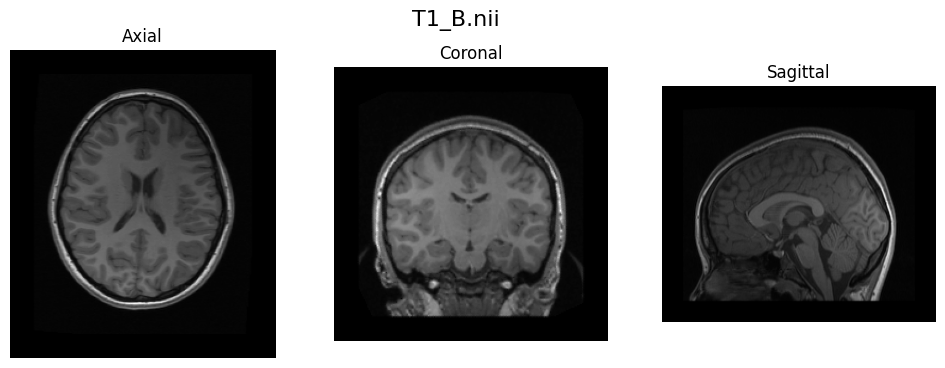

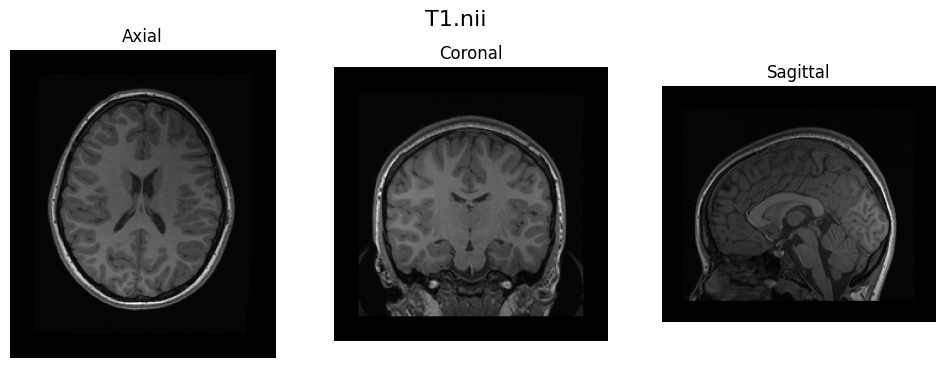

In [18]:
imshow_orthogonal_view(ImgT1_B, title='T1_B.nii')
imshow_orthogonal_view(vol_sitk, title='T1.nii')